In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, t
from scipy import stats
import statsmodels.api as sm
from arch.univariate import arch_model
#from tensorflow.python.kernel_tests.random.util import anderson_darling

In [3]:
df = pd.read_csv('../data/QRM-2025-cw1-data-a.csv')
df_nodelay = df['Adj Close']
df_delay = df['Adj Close'].shift(1)
df['log_return'] = (np.log(df_nodelay) - np.log(df_delay)) * 100
df

,Date,Adj Close,log_return
0,30/10/2013,3040.689941,NaN
1,31/10/2013,3067.949951,0.892513
2,01/11/2013,3052.139893,-0.516662
3,04/11/2013,3061.179932,0.295749
4,05/11/2013,3035.919922,-0.828596
...,...,...,...
2507,23/10/2023,4041.750000,0.423238
2508,24/10/2023,4065.370117,0.582702
2509,25/10/2023,4073.350098,0.196099
2510,26/10/2023,4049.399902,-0.589708


In [4]:
# Part (i):

mu = df['log_return'].mean()
std = df['log_return'].std()
s = df['log_return'].skew()
k = df['log_return'].kurtosis()
print(f'log_return_mean: {mu:.5f}')
print(f'log_return_std: {std:.5f}')
print(f'log_return_skewness: {s:.5f}')
print(f'log_return_kurtosis: {k:.5f}')
print()
print(df['log_return'].describe())

log_return_mean: 0.01178
log_return_std: 1.23914
log_return_skewness: -0.79597
log_return_kurtosis: 10.27807

count    2505.000000
mean        0.011775
std         1.239143
min       -13.240515
25%        -0.545915
50%         0.057402
75%         0.619008
max         8.834255
Name: log_return, dtype: float64


The key takeaway here is that the (log) return distribution is that the returns has a small positive mean (positive growth). More importantly, the return is skewed and has a large kurtosis. The skewness of the return is -0.796, indicating that the left tail longer and heavier than the right tail. The kurtosis of the return is 10.3 (excess kurtosis is 7.3). This suggest that the return has a leptokurtic distribution with an acute peak and heavy tails. These summary statistics suggests that the distribution of the return diviates from that of a normal distribution which is symmetric and zero excess kurtosis. 

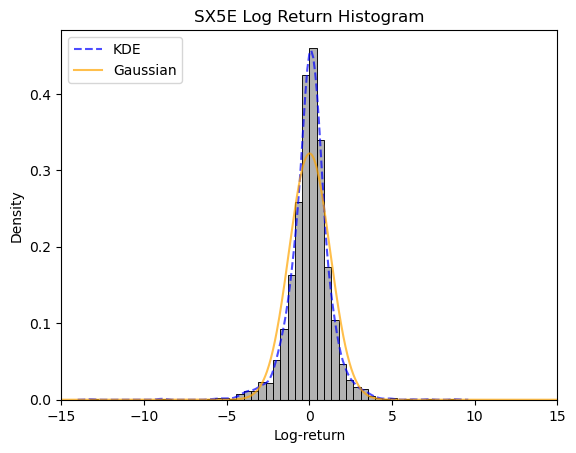

In [7]:
# Part (i)
# Plot histogram of SX5E daily log return, kernel density estimate and the fitted Gaussian pdf.

x = np.linspace(-15,15,1000)

ax = sns.histplot(data=df['log_return'], color="gray", alpha = 0.6, bins=50, stat="density")
sns.kdeplot(data=df['log_return'], color="blue", alpha = 0.7, linestyle="--", label = 'KDE')
ax.plot(x,norm.pdf(x,mu,std),color = "orange", alpha = 0.7, label = 'Gaussian')
ax.set(xlabel='Log-return', ylabel='Density',title = 'SX5E Log Return Histogram')
ax.set_xlim(-15, 15)
ax.legend(loc = "upper left")
plt.show()

The figure futher confirms our observation that the return does not follow a normal distribution. The kernel density estimator of the returns (blue) has a higher peak and thicker tail than the normal distribution fitted using the sample mean and variance. 

/var/folders/8r/3zm2l1394xd4csr0s28nfnbh0000gn/T/ipykernel_42936/4108093624.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc = "upper left")


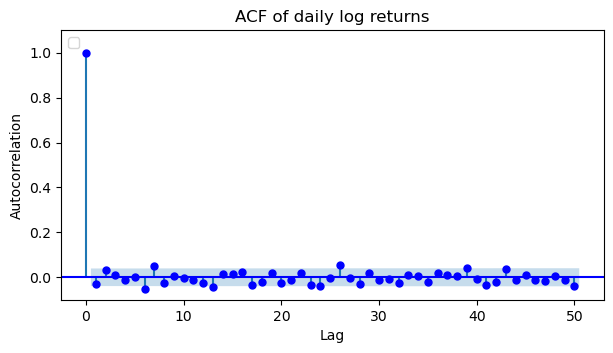

In [20]:
# Part (ii):
# Plot ACF of log return, absolute log return, and squared log return.

fig, ax = plt.subplots(figsize=(7, 3.5))

sm.graphics.tsa.plot_acf(
    df['log_return'].dropna(),
    lags=50,
    ax=ax,
    color="blue",
)

ax.set_title("ACF of daily log returns")
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation")
ax.set_ylim(-0.1, 1.1)

plt.show()

(log) returns are serially uncorrealated.

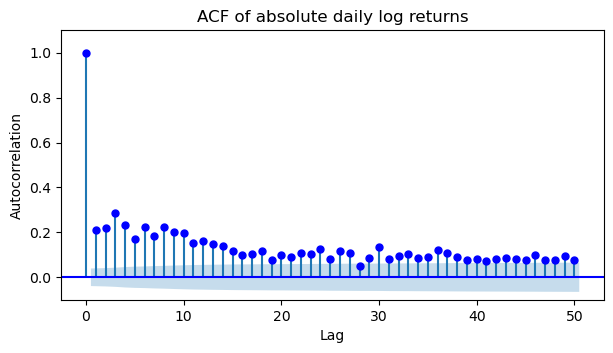

In [22]:
fig, ax = plt.subplots(figsize=(7, 3.5))

sm.graphics.tsa.plot_acf(
    np.abs(df['log_return']).dropna(),
    lags=50,
    ax=ax,
    color="blue",
)

ax.set_title("ACF of absolute daily log returns")
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation")
ax.set_ylim(-0.1, 1.1)

plt.show()

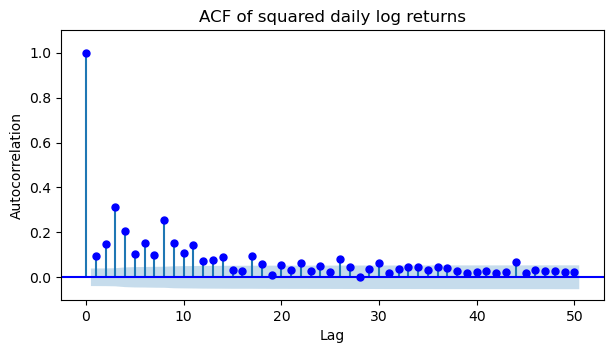

In [24]:
fig, ax = plt.subplots(figsize=(7, 3.5))

sm.graphics.tsa.plot_acf(
    (df['log_return'] ** 2).dropna(),
    lags=50,
    ax=ax,
    color="blue",
)

ax.set_title("ACF of squared daily log returns")
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation")
ax.set_ylim(-0.1, 1.1)

plt.show()

Both absolute return and squared return display clear positive serial correlation. This reflect the clustering and persistence nature of volatility.

A couple of questions here: why is the update frequency chosen to be 9? Does constant conditional mean indicate that its a ARMA-GARCH, but without the ARMA bits? Here I modified "zero" mean to "constant mean" and the fit is slightly different.

Mean is zero vs mean is constant: Does it matter? Practically, daily returns often have a very small mean compared to volatility. Estimating mu vs fixing it at zero usually has a tiny effect on GARCH parameters

In [27]:
# Part (iii): Fit a GARCH(1,1) model

model = arch_model(df['log_return'].dropna(), mean='constant', p=1, q=1, dist='normal')
# "mean=zero" refers to no ARMA component
# "dist=normal" refers to N(0,1) distribution of the white noise process Z
res = model.fit(update_freq = 3)
res.summary()

Iteration:      3,   Func. Count:     23,   Neg. LLF: 5150.7296319685665
Iteration:      6,   Func. Count:     43,   Neg. LLF: 3738.959989943326
Iteration:      9,   Func. Count:     58,   Neg. LLF: 3738.920100041304
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3738.920093281569
            Iterations: 11
            Function evaluations: 67
            Gradient evaluations: 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3738.92
Distribution:                  Normal   AIC:                           7485.84
Method:            Maximum Likelihood   BIC:                           7509.14
                                        No. Observations:                 2505
Date:                Sun, Nov 16 2025   Df Residuals:                     2504
Time:                        19:06:09   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0476  2.019e-02      2.360  1.830e-02 [8.068e-03,8.721e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0596  1.907e-02      3.127  1.765e-03 [2.226e-02,9.700e-02]
alpha[1]       0.1390  3.055e-02      4.551  5.345e-06   [7.914e-02,  0.199]
beta[1]        0.8243  3.461e-02     23.815 2.360e-125     [  0.756,  0.892]
============================================================================

Covariance estimator: robust
"""

When reporting the result. It is important to first state the equation of the model fitted. For this question the equation is $X_{t} = \mu + \sigma_{t}Z_{t}$ where $\sigma_{t}^2 = \omega + \alpha_1X_{t-1}^2 + \beta_1\sigma_{t-1}^2$ for t in the natural numbers.

The fitted values of the mean model and the volatility model (coef, std err, t, p-value, 95% CI) should be reported in the form of the table listed in the template. It is also worth breifly discussing the AIC and BIC.

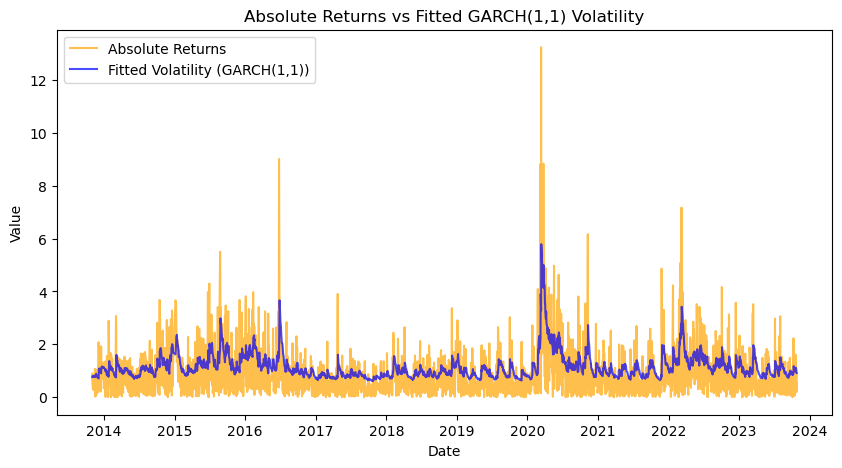

In [28]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df2 = df.dropna(subset=['log_return']).copy()
abs_ret = df2['log_return'].abs()
vol = pd.Series(res.conditional_volatility, index=df2.index)
dates = df2['Date']

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(dates, abs_ret, label='Absolute Returns', alpha=0.7, color = 'orange')
ax.plot(dates, vol, label='Fitted Volatility (GARCH(1,1))', linewidth=1.5, alpha=0.7, color = 'blue')

ax.set_title('Absolute Returns vs Fitted GARCH(1,1) Volatility')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.legend(loc = "upper left")
plt.show()

Interpretation? Perhaps it is helpful to refer back to the lecture and see what Anthony said.

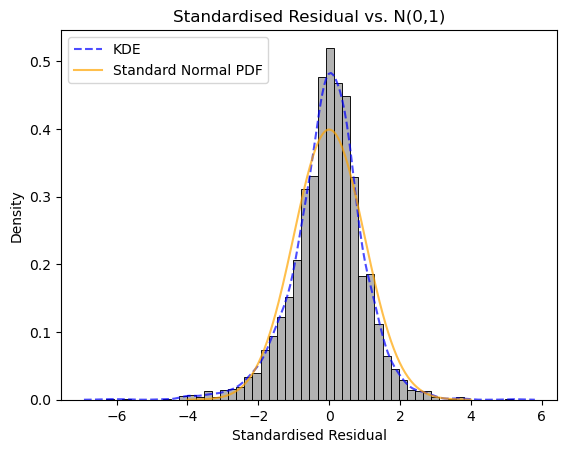

In [30]:
std_resid = res.std_resid
x = np.linspace(-4, 4, 200)
ax = sns.histplot(std_resid, color="gray", alpha = 0.6, bins=50, stat="density")
sns.kdeplot(data=std_resid, color="blue", alpha = 0.7, linestyle="--", label = 'KDE')
ax.plot(x,stats.norm.pdf(x),color = "orange", alpha = 0.7, label = 'Standard Normal PDF')
ax.set(xlabel='Standardised Residual', ylabel='Density',title = 'Standardised Residual vs. N(0,1)')
plt.legend(loc = "upper left")
plt.show()

Plotting the historgram of the standardised residuals and comparing the KDE with the density of standard normal distribution, the standardised residuals does not look like an iid sample from the standard normal distribution (which is $F_{Z}$). This suggest that the process might not be correctly specified.

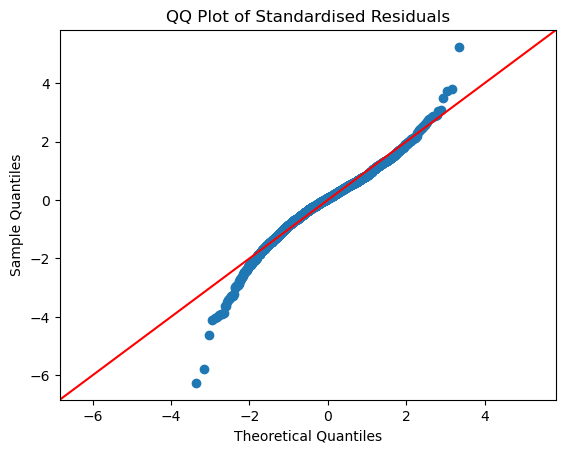

In [32]:
# need to modify the style
sm.qqplot(std_resid, line='45', fit=True)
plt.title('QQ Plot of Standardised Residuals')
plt.show()

Similar result can be conlcuded by looking at the QQ plot. Looking at the lower and upper quantiles, we can see that it deviates from the line $y = x$. The lower sample quantiles are smaller than that of a standard normal distribution, while the upper sample quantiles are larger than that of the standard normal distribution. This suggest that the standardised residuals have thicker tails than the standard normal distribution.

In [33]:
jb_stat, jb_p = stats.jarque_bera(std_resid)
print(f'Jarque–Bera test: statistic={jb_stat:.2f}, p-value={jb_p:.4f}\n'
      f'As p-value is small, we reject the null hypothesis that the standardised residual obeys a distribution of N(0,1).\n')

ad_res = stats.anderson(std_resid, dist = 'norm')
print(f'Anderson-Darling test:\n'
      f'statistic = {ad_res.statistic:.2f}\n'
      f'critical value with significance level 1% = {ad_res.critical_values[-1]:.2f}\n'
      f'Therefore we reject the null hypothesis that the standardised residual obeys a distribution of N(0,1).')

Jarque–Bera test: statistic=805.52, p-value=0.0000
As p-value is small, we reject the null hypothesis that the standardised residual obeys a distribution of N(0,1).

Anderson-Darling test:
statistic = 14.05
critical value with significance level 1% = 1.09
Therefore we reject the null hypothesis that the standardised residual obeys a distribution of N(0,1).


These are some normality tests (test for distribution). Previously, I have used the Shapiro test, and in Statistical Methods, we have used the Kolmogorov Smirnov test. It is our choice and any one of these will do. 

In [23]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_resid = acorr_ljungbox(std_resid, return_df=True)
lb_sq = acorr_ljungbox(std_resid**2, return_df=True)

print("Ljung-Box test for residuals:")
print(lb_resid)
print("\nLjung-Box test for squared residuals:")
print(lb_sq)

Ljung-Box test for residuals:
     lb_stat  lb_pvalue
1   0.345500   0.556671
2   0.534177   0.765605
3   0.626204   0.890408
4   0.865873   0.929405
5   1.356488   0.929013
6   1.357565   0.968389
7   1.567780   0.979870
8   1.792460   0.986727
9   1.821502   0.993986
10  1.868157   0.997254

Ljung-Box test for squared residuals:
      lb_stat  lb_pvalue
1    0.538483   0.463062
2    1.294516   0.523479
3    4.483273   0.213787
4    4.519307   0.340264
5    6.174686   0.289590
6    6.278209   0.392757
7    6.333688   0.501371
8    6.395836   0.602983
9    6.484143   0.690654
10  11.195238   0.342511


The same goes for this.

In [81]:
index = [f'{i}' for i in range(1,10001)]
data = np.random.randn(10000)
df = pd.Series(data = data, index = index, name = 'data1')
df2 = pd.Series(data = data, index = index)
x = pd.concat([df, df2], axis = 0, names = 'First')
x.columns = ['First','Second']
x

1       -0.303160
2       -1.085785
3        0.453536
4        0.564955
5       -1.103775
           ...   
9996    -1.480137
9997     0.893023
9998     1.017933
9999     0.068392
10000    0.082075
Length: 20000, dtype: float64

What is this?

#(v) Fit an ARMA(1,1)–GARCH(1,1) model with Student t-distributed innovations.

Idea: 1: Replicate the method provided in the python notebook given by Anthony. Manually write solve the optimization problem for MLEs.

Idea 2: A two-step approach: Fit ARMA(1,1) to the returns using statsmodels, get residuals, then fit GARCH(1,1) with Student-t on those residuals (mean='zero' for the GARCH stage because the ARMA removed the conditional mean). This is not the same as a joint estimation.

## Fitting an ARMA(1,1)-GARCH(1,1)-Student-t model

In the final example, we consider an ARMA(1,1)-GARCH(1,1) model
\begin{align}
X_{t}&=\mu_t+\sigma_t Z_t,\\
\mu_t&=\mu+\phi_1(X_{t-1}-\mu)+\theta_1 (X_{t-1}-\mu_{t-1}),\\
\sigma_t^2&=\alpha_0+\alpha_1 (X_{t-1} - \mu_{t-1})^2 + \beta_1\sigma_{t-1}^2,
\end{align}
where $(Z_t)_t$ follows a normalised Student-t distribution with degree of freedom $\nu$.

The likelihood function $$\ell(\alpha_0,\alpha_1,\beta_1, \mu,\phi_1,\theta_1, \nu;X)=\sum_{t=1}^T \left[-\log \sigma_t + \log f_Z\left(\frac{X_t-\mu_t}{\sigma_t}\right)\right]$$
 is implemented as follow.

In [69]:
df3 = df['log_return'].dropna()

def arma11_garch11_t_loglikelihood(alpha0, alpha1, beta1, arma_mu, phi1, theta1, nu, x):

    # store time series of sigma_t^2 and mu_t
    var = np.zeros_like(x)
    mu = np.zeros_like(x)

    # set up proxies for sigma_0^2 and \mu_0
    var[0] = np.var(x, ddof=1) # sample variance
    mu[0] = np.mean(x) # sample mean

    # iterate over the ARMA(1,1)-GARCH(1,1) dynamics
    for i in range(1, len(x)):
        mu[i] = arma_mu + phi1 * (x.iloc[i-1] - arma_mu) + theta1 * (x.iloc[i-1] - mu[i-1])
        var[i] = alpha0 + alpha1 * (x.iloc[i-1] - mu[i-1])**2 + beta1 * var[i-1]

    return np.sum(-0.5*np.log(var[1:]) + np.log(t.pdf((x.iloc[1:]-mu[1:])/np.sqrt(var[1:]), nu, 0, np.sqrt((nu-2)/nu))))

In [70]:
from scipy.optimize import minimize

objfun_armagarch_t = lambda y : -1 * arma11_garch11_t_loglikelihood(y[0], y[1], y[2], y[3], y[4], y[5], y[6], df3)
constraint = lambda y :  1 - y[1] - y[2]

uncond_var = np.var(df3, ddof=1)
alpha1_0 = 0.1
beta1_0  = 0.85
alpha0_0 = uncond_var * (1 - alpha1_0 - beta1_0)

arma_0 = ARIMA(df3, order=(1, 0, 1)).fit()

arma_mu_0 = df3.mean()
phi1_0   = arma_0.params.get("ar.L1", 0.0)
theta1_0 = arma_0.params.get("ma.L1", 0.0)


y0 = [alpha0_0, alpha1_0, beta1_0, arma_mu_0, phi1_0, theta1_0, 10]
print("Initial objective function value: " + str(objfun_armagarch_t(y0)))

bnds = ((0,np.inf), (0,1), (0,1), (-np.inf, np.inf), (-np.inf, np.inf), (-np.inf, np.inf), (2.01, np.inf))

con = {'type': 'ineq', 'fun': constraint}

sol = minimize(objfun_armagarch_t,y0,method='SLSQP',bounds=bnds,constraints=con, options={'disp': True})

print("Estimate of alpha0: " + str(sol.x[0]))
print("Estimate of alpha1: " + str(sol.x[1]))
print("Estimate of beta1: " + str(sol.x[2]))
print("Estimate of mu: " + str(sol.x[3]))
print("Estimate of phi1: " + str(sol.x[4]))
print("Estimate of theta1: " + str(sol.x[5]))
print("Estimate of nu: " + str(sol.x[6]))

/Users/harryqiao/miniconda3/envs/stdpopsim_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/harryqiao/miniconda3/envs/stdpopsim_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/harryqiao/miniconda3/envs/stdpopsim_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Initial objective function value: 3678.230863962106


/var/folders/8r/3zm2l1394xd4csr0s28nfnbh0000gn/T/ipykernel_42936/518517439.py:16: RuntimeWarning: overflow encountered in scalar power
  var[i] = alpha0 + alpha1 * (x.iloc[i-1] - mu[i-1])**2 + beta1 * var[i-1]
/var/folders/8r/3zm2l1394xd4csr0s28nfnbh0000gn/T/ipykernel_42936/518517439.py:15: RuntimeWarning: overflow encountered in scalar multiply
  mu[i] = arma_mu + phi1 * (x.iloc[i-1] - arma_mu) + theta1 * (x.iloc[i-1] - mu[i-1])
/var/folders/8r/3zm2l1394xd4csr0s28nfnbh0000gn/T/ipykernel_42936/518517439.py:16: RuntimeWarning: invalid value encountered in scalar multiply
  var[i] = alpha0 + alpha1 * (x.iloc[i-1] - mu[i-1])**2 + beta1 * var[i-1]
/var/folders/8r/3zm2l1394xd4csr0s28nfnbh0000gn/T/ipykernel_42936/518517439.py:18: RuntimeWarning: divide by zero encountered in log
  return np.sum(-0.5*np.log(var[1:]) + np.log(t.pdf((x.iloc[1:]-mu[1:])/np.sqrt(var[1:]), nu, 0, np.sqrt((nu-2)/nu))))
/var/folders/8r/3zm2l1394xd4csr0s28nfnbh0000gn/T/ipykernel_42936/518517439.py:18: RuntimeWarning:

Optimization terminated successfully    (Exit mode 0)
            Current function value: 3635.092242263233
            Iterations: 29
            Function evaluations: 259
            Gradient evaluations: 29
Estimate of alpha0: 0.04745441343488153
Estimate of alpha1: 0.1476656969984652
Estimate of beta1: 0.8335607639690267
Estimate of mu: 0.06985054184566815
Estimate of phi1: 0.9114265500099736
Estimate of theta1: -0.9335182928566875
Estimate of nu: 4.727205397009915


In [71]:
alpha0_hat = sol.x[0]
alpha1_hat = sol.x[1]
beta1_hat  = sol.x[2]
arma_mu_hat = sol.x[3]
phi1_hat    = sol.x[4]
theta1_hat  = sol.x[5]
nu_hat      = sol.x[6]

def arma11_garch11_paths(params, x):
    """
    Given parameters and a return series x (pd.Series),
    compute mu_t, var_t and standardized residuals z_t.
    """
    alpha0, alpha1, beta1, arma_mu, phi1, theta1, nu = params

    x = x.to_numpy()  # work with ndarray for speed
    n = len(x)

    var = np.empty(n)
    mu  = np.empty(n)

    # Initial values (same as in your likelihood)
    var[0] = np.var(x, ddof=1)
    mu[0]  = np.mean(x)

    for i in range(1, n):
        # Mean recursion: ARMA(1,1)
        mu[i] = arma_mu + phi1 * (x[i-1] - arma_mu) + theta1 * (x[i-1] - mu[i-1])

        # GARCH(1,1) variance recursion
        e_prev = x[i-1] - mu[i-1]
        var[i] = alpha0 + alpha1 * e_prev * e_prev + beta1 * var[i-1]

    # Standardized residuals
    sigma = np.sqrt(var)
    z = (x - mu) / sigma

    # Wrap back into Series with same index as x
    idx = df3.index  # or x_index saved separately if you prefer
    mu_s    = pd.Series(mu,    index=idx, name="mu_hat")
    var_s   = pd.Series(var,   index=idx, name="var_hat")
    sigma_s = pd.Series(sigma, index=idx, name="sigma_hat")
    z_s     = pd.Series(z,     index=idx, name="z_hat")

    return mu_s, var_s, sigma_s, z_s

In [72]:
params_hat = (alpha0_hat, alpha1_hat, beta1_hat,
              arma_mu_hat, phi1_hat, theta1_hat, nu_hat)

mu_hat, var_hat, sigma_hat, z_hat = arma11_garch11_paths(params_hat, df3)
z_std = z_hat.iloc[1:]

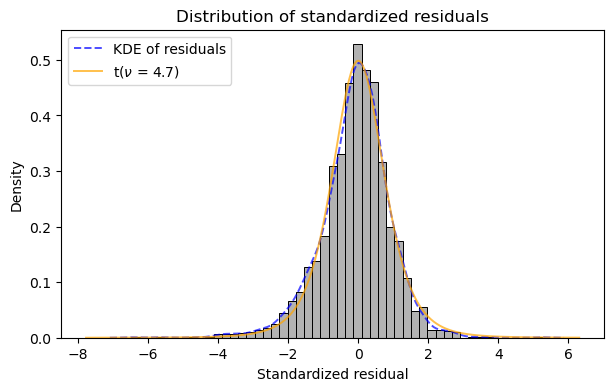

In [73]:
z = z_std.dropna()

# x-grid for the theoretical t density
x_vals = np.linspace(z.min() * 1.2, z.max() * 1.2, 500)

# scale so that Var = 1 (same as in your likelihood)
scale_hat = np.sqrt((nu_hat - 2.0) / nu_hat)

fig, ax = plt.subplots(figsize=(7, 4))

# Histogram of standardized residuals
sns.histplot(
    z,
    bins=50,
    stat="density",
    color="gray",
    alpha=0.6,
    edgecolor="black",
    ax=ax
)

# KDE of standardized residuals
sns.kdeplot(
    z,
    color="blue",
    alpha=0.7,
    linestyle="--",
    linewidth=1.4,
    label="KDE of residuals",
    ax=ax
)

# Fitted t-distribution with nu_hat and scale_hat
ax.plot(
    x_vals,
    t.pdf(x_vals, df=nu_hat, loc=0.0, scale=scale_hat),
    color="orange",
    alpha=0.7,
    linewidth=1.4,
    label=fr"t($\nu$ = {nu_hat:.1f})"
)

ax.set_xlabel("Standardized residual")
ax.set_ylabel("Density")
ax.set_title("Distribution of standardized residuals")

ax.legend(loc="upper left")
plt.show()

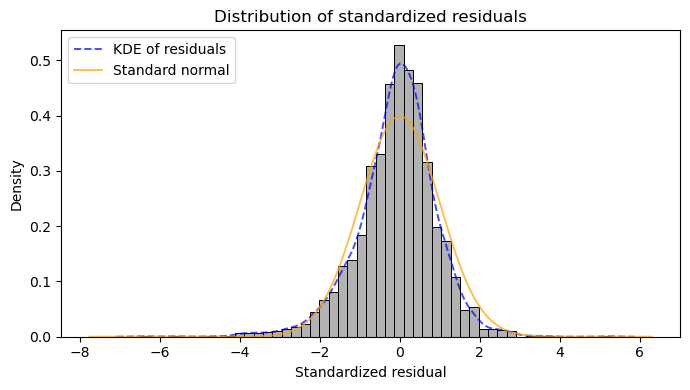

In [74]:
fig, ax = plt.subplots(figsize=(7, 4))

# Histogram of standardized residuals
sns.histplot(
    z,
    bins=50,
    stat="density",
    color="gray",
    alpha=0.6,
    edgecolor="black",
    ax=ax
)

# KDE of standardized residuals
sns.kdeplot(
    z,
    color="blue",
    alpha=0.7,
    linestyle="--",
    linewidth=1.4,
    label="KDE of residuals",
    ax=ax
)

# Standard normal pdf
ax.plot(
    x_vals,
    norm.pdf(x_vals, loc=0, scale=1),
    color="orange",
    alpha=0.7,
    linewidth=1.4,
    label="Standard normal"
)

ax.set_xlabel("Standardized residual")
ax.set_ylabel("Density")
ax.set_title("Distribution of standardized residuals")

ax.legend(loc="upper left")

plt.tight_layout()
plt.show()

Figure X shows the histogram and kernel density estimate of the standardized residuals, overlaid with the fitted t-distribution with ν̂ degrees of freedom. The empirical distribution aligns closely with the t-density, especially in the centre and tails, supporting the assumption of t-distributed innovations. In contrast, a normal density (not shown) would underestimate tail probabilities, indicating heavier-than-normal tails remain even after volatility standardisation.

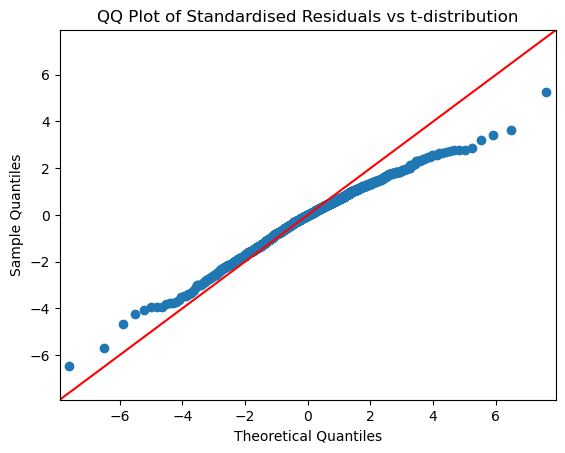

In [75]:
sm.qqplot(z, dist=t, distargs=(nu_hat,), line='45')
plt.title('QQ Plot of Standardised Residuals vs t-distribution')
plt.show()

In [77]:
from scipy.stats import anderson_ksamp
# Simulate reference t-distribution
t_sim = t.rvs(df=nu_hat, loc=0, scale=scale_hat, size=50000, random_state=42)

# Anderson–Darling k-sample test (z vs simulated t-dist)
ad_stat, crit_vals, sig_level = anderson_ksamp([z, t_sim])

print(f"Anderson–Darling test against t(ν={nu_hat:.2f}):\n"
      f"Statistic = {ad_stat:.4f}\n"
      f"Significance level = {sig_level:.4f}\n")

if sig_level < 0.05:
    print("→ Reject the null hypothesis: standardized residuals do NOT follow a t-distribution with the fitted ν.")
else:
    print("→ Fail to reject the null hypothesis: standardized residuals are CONSISTENT with a t-distribution with the fitted ν.")

Anderson–Darling test against t(ν=4.73):
Statistic = 3.7484
Significance level = 0.0100

→ Reject the null hypothesis: standardized residuals do NOT follow a t-distribution with the fitted ν.


In [51]:
#Idea 2
from statsmodels.tsa.arima.model import ARIMA

# 1) Fit ARMA(1,1) to the raw returns
arma = ARIMA(df3, order=(1,0,1)).fit()
arma.summary()

# 2) Get residuals from ARMA and fit GARCH(1,1) with Student-t
resid = arma.resid  # these are the mean-filtered residuals

garch_on_resid = arch_model(resid, mean='zero', p=1, q=1, dist='t')
garch_res = garch_on_resid.fit(update_freq=5, disp='off')
print(garch_res.summary())

# Conditional vol from the GARCH fit (aligned to resid index)
cond_vol = garch_res.conditional_volatility

/Users/harryqiao/miniconda3/envs/stdpopsim_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/harryqiao/miniconda3/envs/stdpopsim_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/harryqiao/miniconda3/envs/stdpopsim_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                          Zero Mean - GARCH Model Results                           
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -3644.23
Distribution:      Standardized Student's t   AIC:                           7296.45
Method:                  Maximum Likelihood   BIC:                           7319.76
                                              No. Observations:                 2505
Date:                      Mon, Nov 17 2025   Df Residuals:                     2505
Time:                              09:26:02   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omeg

Key issue of idea 2 is that first fitting a ARMA(1, 1) then fit a GARCH(1, 1) on the residuals is not the same as fitting them alltogether.

Now do it without the ARMA(1,1)

In [79]:
model2 = arch_model(df['log_return'].dropna(), mean='constant', p=1, q=1, dist='t')
res2 = model2.fit(update_freq = 3)
res2.summary()

Iteration:      3,   Func. Count:     26,   Neg. LLF: 6823.77749354809
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3642.4660698273633
Iteration:      9,   Func. Count:     70,   Neg. LLF: 3639.8992305882166
Iteration:     12,   Func. Count:     88,   Neg. LLF: 3639.8954625192596
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3639.8954625192596
            Iterations: 13
            Function evaluations: 93
            Gradient evaluations: 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                   log_return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -3639.90
Distribution:      Standardized Student's t   AIC:                           7289.79
Method:                  Maximum Likelihood   BIC:                           7318.92
                                              No. Observations:                 2505
Date:                      Mon, Nov 17 2025   Df Residuals:                     2504
Time:                              11:19:54   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0681  1.715e-02      3.969  7.218e-05 [3.445e-02,  0.102]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0467  1.409e-02      3.313  9.236e-04 [1.906e-02,7.430e-02]
alpha[1]       0.1457  2.780e-02      5.240  1.605e-07   [9.117e-02,  0.200]
beta[1]        0.8349  2.892e-02     28.867 3.121e-183     [  0.778,  0.892]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             4.8460      0.465     10.421  1.998e-25 [  3.935,  5.757]
========================================================================

Covariance estimator: robust
"""

Needs to plot the residuals plot, qq plot and evaluate whether the ARMA(1, 1) part is necessary. If the fit is not significantly worse, than the ARMA(1, 1) is not needed.